# Importing & Preparing Data

In [93]:
from google.colab import files
uploaded = files.upload()

Saving sp.csv to sp (1).csv


In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import io
df = pd.read_csv(io.BytesIO(uploaded['sp.csv'])) 
df = df.sort_values(by = 'DATE')
df['lnret'] = np.log(1+df['sprtrn'])
df['sqlnret'] = df['lnret']**2
df.head()

,DATE,sprtrn,spindx,lnret,sqlnret
0,19630102,-0.006498,62.69,-0.006519,4.250002e-05
1,19630103,0.016430,63.72,0.016296,2.655755e-04
2,19630104,0.006434,64.13,0.006413,4.113157e-05
3,19630107,-0.000156,64.12,-0.000156,2.433980e-08
4,19630108,0.009669,64.74,0.009623,9.259355e-05


# Exploratory Data Analysis

We decided to use log returns as they are assumed to better fit the normality assumption.

In [0]:
df['lnret'] = np.log(1+df['sprtrn'])

In [0]:
df['sqlnret'] = df['lnret']**2

Let's check the normality assumption by conducting a Jarque-Bera Test. We will test the null hypothesis that daily returns are normally distributed. 

In [0]:
stats.jarque_bera(df['lnret'])

(435247.0031345941, 0.0)

With a p-value of close to 0 and a test statistic of 435,247, we can reject the null hypothesis.
This suggests that daily log returns are not normally distributed. 

Let's figure out where the abnormality comes from.

In [0]:
stats.kurtosis(df['lnret'])

[Scipy.stats.kurtosis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html) calculates Fisher's definition of kurtosis by default. Thus 3 is subtracted from the result and the xxx is excess kurtosis (compared to a normal distribution, which has a kurtosis of 3). Consequently, we can observe that the distribution hat fat tails and the probability for the occurence of more extreme outliers is larger than in a normal distribution. 

In [0]:
stats.skew(df['lnret'])

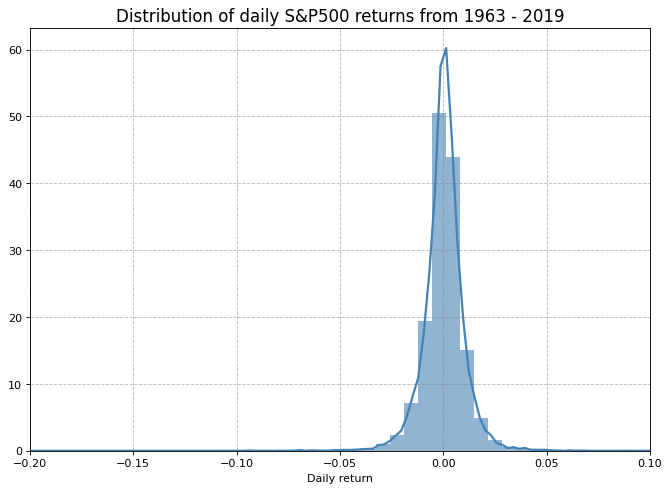

In [0]:
%matplotlib inline
fig = plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(df['lnret'], label='daily log returns', color = 'steelblue', **kwargs)
plt.xlim(-0.2,0.1)
plt.title('Distribution of daily S&P500 returns from 1963 - 2019', fontsize = 15)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')
plt.xlabel('Daily return')
plt.show()

As one can see 

## Volatiltiy Clustering

Let's plot the squared log returns to look for evidence of volatility clustering. 

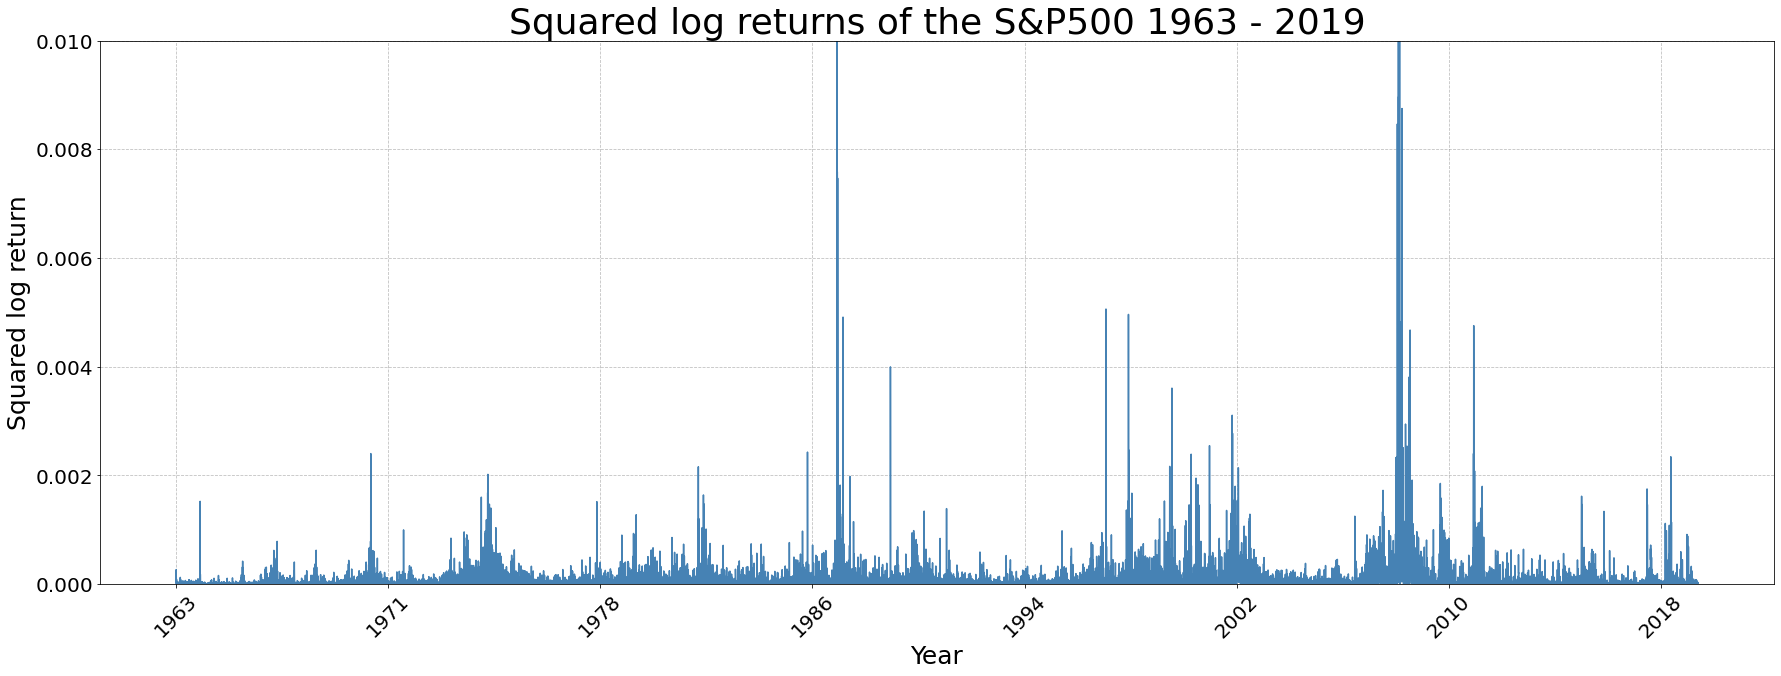

In [0]:
%matplotlib inline
df['YEAR'] = df['DATE'].astype(str)
df['YEAR']= df['YEAR'].str.slice(0, 4, 1)
df = df.set_index('YEAR')
fig = df.sqlnret.plot(figsize = (30,10), color = 'steelblue')
plt.rcParams.update({'font.size': 30})
plt.yticks(fontsize = 20)
plt.ylim(0,0.01)
plt.ylabel('Squared log return', fontsize = 25)
plt.xticks(fontsize = 20, rotation = 45)
plt.xlabel ('Year', fontsize = 25)
plt.title('Squared log returns of the S&P500 1963 - 2019')
df = df.reset_index()
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')
plt.show()

We can clearly see volatility clustering in times of financial distress (global financial crisis, dot-com bubble, etc.)  

# Building the deep neural networks

### Importing Packages

In [0]:
import tensorflow
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

In [0]:
#Splitting the data into train and test
data = df['spindx'].to_numpy()
data = data.reshape(-1,1)
data_train = data[:int(0.8*(len(df)))]
data_test = data[int(0.8*(len(df))):]

In [0]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)

In [0]:
#building time series 
batch_size = 1
features = 1
time_steps = 10
num_steps_train = len(train_scaled) - time_steps
X_train = np.zeros([num_steps_train, time_steps, features])
y_train = np.zeros(num_steps_train)
for step in range(num_steps_train):
  X_train[step, :time_steps] = train_scaled[step:step + time_steps]
  y_train[step] = train_scaled[step + time_steps]

num_steps_test = len(test_scaled) - time_steps
X_test = np.zeros([num_steps_test, time_steps, features])
y_test = np.zeros(num_steps_test)
for step in range(num_steps_test):  
  X_test[step, :time_steps] = test_scaled[step:step + time_steps]
  y_test[step] = test_scaled[step + time_steps]


## Building the LSTM Model

In [0]:
#Version 2
lr = 0.001
decay = 1e-6
optimizer = Adam()

model = Sequential()
#ohne Aktivierungsfunktion wird automatisch ein CuDNNLSTM verwendet, was deutlich schleer sein soll
model.add(LSTM(256, input_shape = X_train.shape[1:], return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', 
                   optimizer=optimizer)
 
#csv_logger = CSVLogger(('log_file' + '.log'), append=True)

history_LSTM = model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
180/180 [==============================] - 19s 107ms/step - loss: 0.0141
Epoch 2/50
180/180 [==============================] - 20s 110ms/step - loss: 0.0055
Epoch 3/50
180/180 [==============================] - 19s 107ms/step - loss: 0.0041
Epoch 4/50
180/180 [==============================] - 19s 104ms/step - loss: 0.0037
Epoch 5/50
180/180 [==============================] - 19s 104ms/step - loss: 0.0033
Epoch 6/50
180/180 [==============================] - 19s 103ms/step - loss: 0.0032
Epoch 7/50
180/180 [==============================] - 19s 105ms/step - loss: 0.0031
Epoch 8/50
180/180 [==============================] - 19s 107ms/step - loss: 0.0030
Epoch 9/50
180/180 [==============================] - 19s 104ms/step - loss: 0.0028
Epoch 10/50
180/180 [==============================] - 19s 104ms/step - loss: 0.0029
Epoch 11/50
180/180 [==============================] - 19s 104ms/step - loss: 0.0026
Epoch 12/50
180/180 [==============================] - 19s 107ms/step - lo

In [0]:
model.save("LSTM.h5")

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred = model.predict(X_test)
plt.plot(y_pred, label = 'pred')
plt.plot(y_test, label = 'actual')
plt.legend()
plt.show()

## Building a commonly used deep neural network

In [0]:
#building time series 
batch_size = 1
time_steps = 10
num_steps = len(df) - time_steps
X = np.zeros([num_steps, time_steps])
y = np.zeros(num_steps)

for step in range(num_steps):
  X[step, :time_steps] = df['spindx'][step:step + time_steps]
  y[step] = df['spindx'][step + time_steps]

#split the data
X_train = X[:int(0.8*len(df)), :time_steps]
X_test = X[int(0.8*len(df))+1:, :time_steps]

y_train = y[:int(0.8*len(df))]
y_test = y[int(0.8*len(df))+1:] 

In [0]:
model = Sequential()
#ohne Aktivierungsfunktion wird automatisch ein CuDNNLSTM verwendet, was deutlich schleer sein soll
model.add(Dense(256,activation='relu', input_shape = X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', 
                   optimizer=optimizer)
 
#csv_logger = CSVLogger(('log_file' + '.log'), append=True)

history_DNN = model.fit(X_train, y_train, epochs=50, batch_size=64)

In [0]:
model.save('DNN.h5')

In [0]:
y_pred = model.predict(X_test)

In [0]:
plt.plot(y_pred, label = 'pred')
plt.plot(y_test, label = 'actual')
plt.legend()
plt.show()